In [ ]:
import kagglehub
jessicali9530_celeba_dataset_path = kagglehub.dataset_download('jessicali9530/celeba-dataset')

print('Data source import complete.')


# Image Super-Resolution using U-Net

This notebook demonstrates how to build and train a U-Net model for image super-resolution.  
The goal is to take a low-resolution image (64x64) and generate a high-resolution version (256x256).

The U-Net architecture is well-suited for this task as it effectively captures both local and global features through its encoder-decoder structure with skip connections.




### 1. Setup and Imports

This cell imports all the necessary libraries for building and training the U-Net model, including Keras for model definition, OpenCV for image processing, and Matplotlib for visualization.

In [ ]:
import os
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

### 2. U-Net Model Definition

This cell defines the U-Net model architecture for image super-resolution. The `unet_64to256` function creates a U-Net model that takes a 64x64x3 image as input and outputs a 256x256x3 image. It includes an encoder, a bottleneck, and a decoder with skip connections.

In [ ]:
def unet_64to256(input_shape=(64, 64, 3), n_classes=3, final_activation='sigmoid', dropout_rate=0.05):
    inputs = Input(shape=input_shape, name='img')

    # Encoder (64 -> 4)
    c1 = Conv2D(16, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3,3), padding='same')(c1)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2,2))(c1); p1 = Dropout(dropout_rate)(p1)   # 64 -> 32

    c2 = Conv2D(32, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3,3), padding='same')(c2)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2,2))(c2); p2 = Dropout(dropout_rate)(p2)   # 32 -> 16

    c3 = Conv2D(64, (3,3), padding='same')(p2)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3,3), padding='same')(c3)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2,2))(c3); p3 = Dropout(dropout_rate)(p3)   # 16 -> 8

    c4 = Conv2D(128, (3,3), padding='same')(p3)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3,3), padding='same')(c4)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    p4 = MaxPooling2D((2,2))(c4); p4 = Dropout(dropout_rate)(p4)   # 8 -> 4

    # Bottleneck (4x4)
    c5 = Conv2D(256, (3,3), padding='same')(p4)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3,3), padding='same')(c5)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)

    # Decoder (back to 256x256)
    u6 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(c5)  # 4 -> 8
    u6 = concatenate([u6, c4]); u6 = Dropout(dropout_rate)(u6)
    u6 = Conv2D(128, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)
    u6 = Conv2D(128, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)

    u7 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(u6)    # 8 -> 16
    u7 = concatenate([u7, c3]); u7 = Dropout(dropout_rate)(u7)
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)

    u8 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(u7)    # 16 -> 32
    u8 = concatenate([u8, c2]); u8 = Dropout(dropout_rate)(u8)
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)

    u9 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u8)    # 32 -> 64
    u9 = concatenate([u9, c1]); u9 = Dropout(dropout_rate)(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)

    # Extra upsample to reach 256x256 (no skip)
    u10 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u9)   # 64 -> 128
    u10 = Dropout(dropout_rate)(u10)
    u10 = Conv2D(16, (3,3), padding='same')(u10)
    u10 = BatchNormalization()(u10); u10 = Activation('relu')(u10)

    u11 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u10)   # 128 -> 256
    u11 = Dropout(dropout_rate)(u11)
    u11 = Conv2D(16, (3,3), padding='same')(u11)
    u11 = BatchNormalization()(u11); u11 = Activation('relu')(u11)


    outputs = Conv2D(n_classes, (1,1), activation=final_activation, name='mask')(u11)

    return Model(inputs=inputs, outputs=outputs, name='UNet_64to256')

### 3. Model Initialization and Compilation

This cell initializes the U-Net model with the specified input shape and number of classes. It then compiles the model using the Adam optimizer and mean absolute error (MAE) as the loss function. The input and output shapes are printed to verify the model architecture.

In [ ]:
model = unet_64to256(input_shape=(64,64,3), n_classes=3, final_activation='sigmoid')

print('Input shape:', model.input_shape)   # (None, 64, 64, 3)
print('Output shape:', model.output_shape) # (None, 256, 256, 3)

model.compile(optimizer=Adam(1e-4), loss='mae' )

Input shape: (None, 64, 64, 3)
Output shape: (None, 256, 256, 3)


### 4. Data Generator

This cell defines a data generator function `datagen` that loads and preprocesses images from the CelebA dataset. It resizes the images to 256x256 as ground truth and to 64x64 as low-resolution input, and normalizes the pixel values. The generator yields batches of low-resolution and high-resolution image pairs for training.

In [ ]:
import os
import cv2 as cv
import numpy as np

imgs = os.listdir('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/')


def datagen(batch_size):

    while True:
        x_batch = []
        y_batch = []

        for _ in range(batch_size):
            indx = np.random.randint(0, len(imgs))

            bgr = cv.imread('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + imgs[indx])
            bgr = cv.resize(bgr, (256, 256))
            rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)


            x = cv.resize(rgb, (64, 64))
            x = x / 255.0
            y = rgb / 255.0

            x_batch.append(x)
            y_batch.append(y)

        x_batch = np.array(x_batch).reshape(batch_size, 64, 64, 3)
        y_batch = np.array(y_batch).reshape(batch_size, 256, 256, 3)

        yield x_batch, y_batch

5. Model Training with Callbacks and Sample Saving

This cell trains the U-Net model for a longer duration (3 epochs) and includes custom callbacks. The `show_and_save_samples` function generates and saves sample super-resolved images at the end of each epoch, along with the original, ground truth, and low-resolution images for comparison. The `LambdaCallback` is used to execute this function after each epoch. The model checkpoints are also saved during training.

6331/6331 [==============================] - ETA: 0s - loss: 0.0421

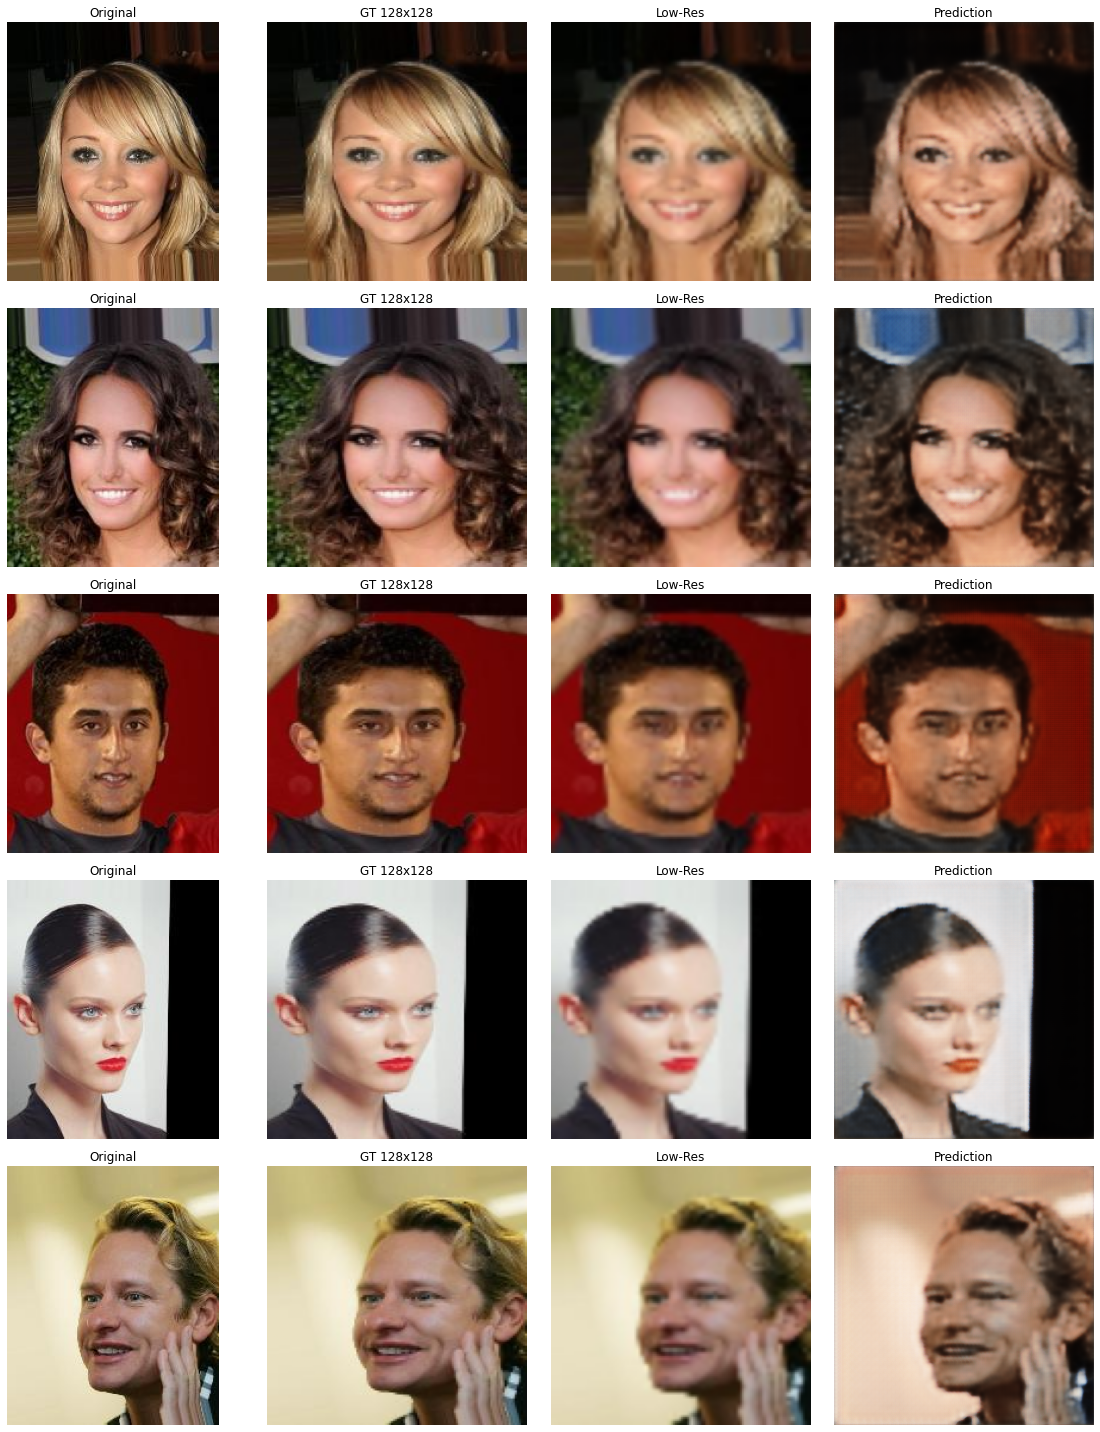

6331/6331 [==============================] - 1317s 208ms/step - loss: 0.0421


In [ ]:
zimport os, cv2 as cv, numpy as np, matplotlib.pyplot as plt, tensorflow as tf

def show_and_save_samples(model, imgs, base_dir, epoch, n=5, save_dir='./epoch_samples'):
    os.makedirs(save_dir, exist_ok=True)
    chosen = np.random.choice(imgs, n, replace=False)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n == 1: axes = np.expand_dims(axes, 0)

    for i, fname in enumerate(chosen):
        path = os.path.join(base_dir, fname)
        rgb = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
        gt128 = cv.resize(rgb, (128,128)).astype('float32')/255
        img64 = cv.resize(rgb, (64,64)).astype('float32')/255
        pred  = model.predict(np.expand_dims(img64,0), verbose=0)[0]
        lowup = cv.resize((img64*255).astype(np.uint8),(128,128))

        for ax, im, title in zip(axes[i],[rgb,gt128,lowup,pred],
                                 ['Original','GT 128x128','Low-Res','Prediction']):
            ax.imshow(im); ax.set_title(title); ax.axis('off')

    plt.tight_layout(); plt.savefig(f"{save_dir}/epoch_{epoch+1:02d}.png"); plt.show()

# --- Simple Callbacks ---
def on_epoch_end(epoch, logs):
    show_and_save_samples(model, imgs, base_dir, epoch, n=5)
    model.save(f'./checkpoints/model_epoch_{epoch+1:02d}.keras')

show_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)


batch_size = 32
steps_per_epoch = len(imgs)//batch_size
base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
os.makedirs('./checkpoints', exist_ok=True)

results = model.fit(
    datagen(batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=1,
    callbacks=[show_cb],
    verbose=1)

### 6. Project Summary

**Objective**
The goal was to apply a U-Net model for image super-resolution, training it on the CelebA dataset to upscale 64×64 inputs into 256×256 outputs.

**Findings**
During training, the mean absolute error (MAE) steadily decreased, confirming that the model was learning effectively. Sample outputs generated at the end of each epoch illustrated clear improvements in image quality and detail reconstruction.